In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")

print("Path to dataset files:", path)

100%|██████████| 2.30G/2.30G [00:26<00:00, 93.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from PIL import Image
from tqdm.auto import tqdm
from typing import Dict
from pathlib import Path
import logging
import time
from prettytable import PrettyTable
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam, lr_scheduler
import torchvision.transforms as tfms
import torchvision.transforms.functional as T
from torchvision.models import resnet50, ResNet50_Weights


import albumentations as A
from albumentations.pytorch import ToTensorV2

## Config

In [3]:
class CFG:
    CLASS_NAMES = [
        "Atelectasis",
        "Cardiomegaly",
        "Effusion",
        "Infiltration",
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia",
    ]
    BASE_PATH = Path(path)
    BEST_MODEL_PATH = "models/best_model.pt"
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    INTERVAL = 10

In [4]:
CFG.DEVICE

device(type='cuda')

## Process Images and labels

In [5]:
df = pd.read_csv( CFG.BASE_PATH / "Data_Entry_2017.csv")

In [6]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [7]:
df = df[["Image Index", "Finding Labels"]]

In [ ]:
df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


In [8]:
# Make paths absolute
df["Image Index"] = [
    CFG.BASE_PATH / f"images-224/images-224/{path}" for path in df["Image Index"].values
]
# Remove "No Finding"
df = df[df["Finding Labels"].isin(["No Finding"]) == False]

In [9]:
df.head(10)

,Image Index,Finding Labels
0,/root/.cache/kagglehub/datasets/khanfashee/nih...,Cardiomegaly
1,/root/.cache/kagglehub/datasets/khanfashee/nih...,Cardiomegaly|Emphysema
2,/root/.cache/kagglehub/datasets/khanfashee/nih...,Cardiomegaly|Effusion
4,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia
5,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia
6,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia
7,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia|Infiltration
8,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia
9,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia
10,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia


In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert label strings to list of labels
label_lists = df["Finding Labels"].str.split("|")

mlb = MultiLabelBinarizer(classes=CFG.CLASS_NAMES)

labels = mlb.fit_transform(label_lists)


In [11]:
labels

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
d = {k:v for k, v in zip(CFG.CLASS_NAMES, labels.transpose())}

In [13]:
for k, v in d.items():
    df[k] = v

In [14]:
df.head()

,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,/root/.cache/kagglehub/datasets/khanfashee/nih...,Cardiomegaly,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,/root/.cache/kagglehub/datasets/khanfashee/nih...,Cardiomegaly|Emphysema,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,/root/.cache/kagglehub/datasets/khanfashee/nih...,Cardiomegaly|Effusion,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [15]:
df.to_csv("final.csv", index=False)

## Plotting images

Now we have our Images and one-hot encoded labels, let's view a few of them

In [16]:
def plot_images(df, rows, columns, figsize=(20, 20)):
    """
    Function to plot images
    """
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    idx = 0
    for i in range(rows):
        for j in range(columns):
            image = np.asarray(Image.open(df["Image Index"].values[idx]).convert("RGB"))
            labels = df["Finding Labels"].values[idx].split("|")
            axs[i, j].imshow(image)
            axs[i, j].yaxis.set_visible(False)
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xlabel(labels)
            idx += 1
    plt.show()

## Read the saved data

In [17]:
df = pd.read_csv("./final.csv")

In [ ]:
df.head()

,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly|Emphysema,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly|Effusion,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,1


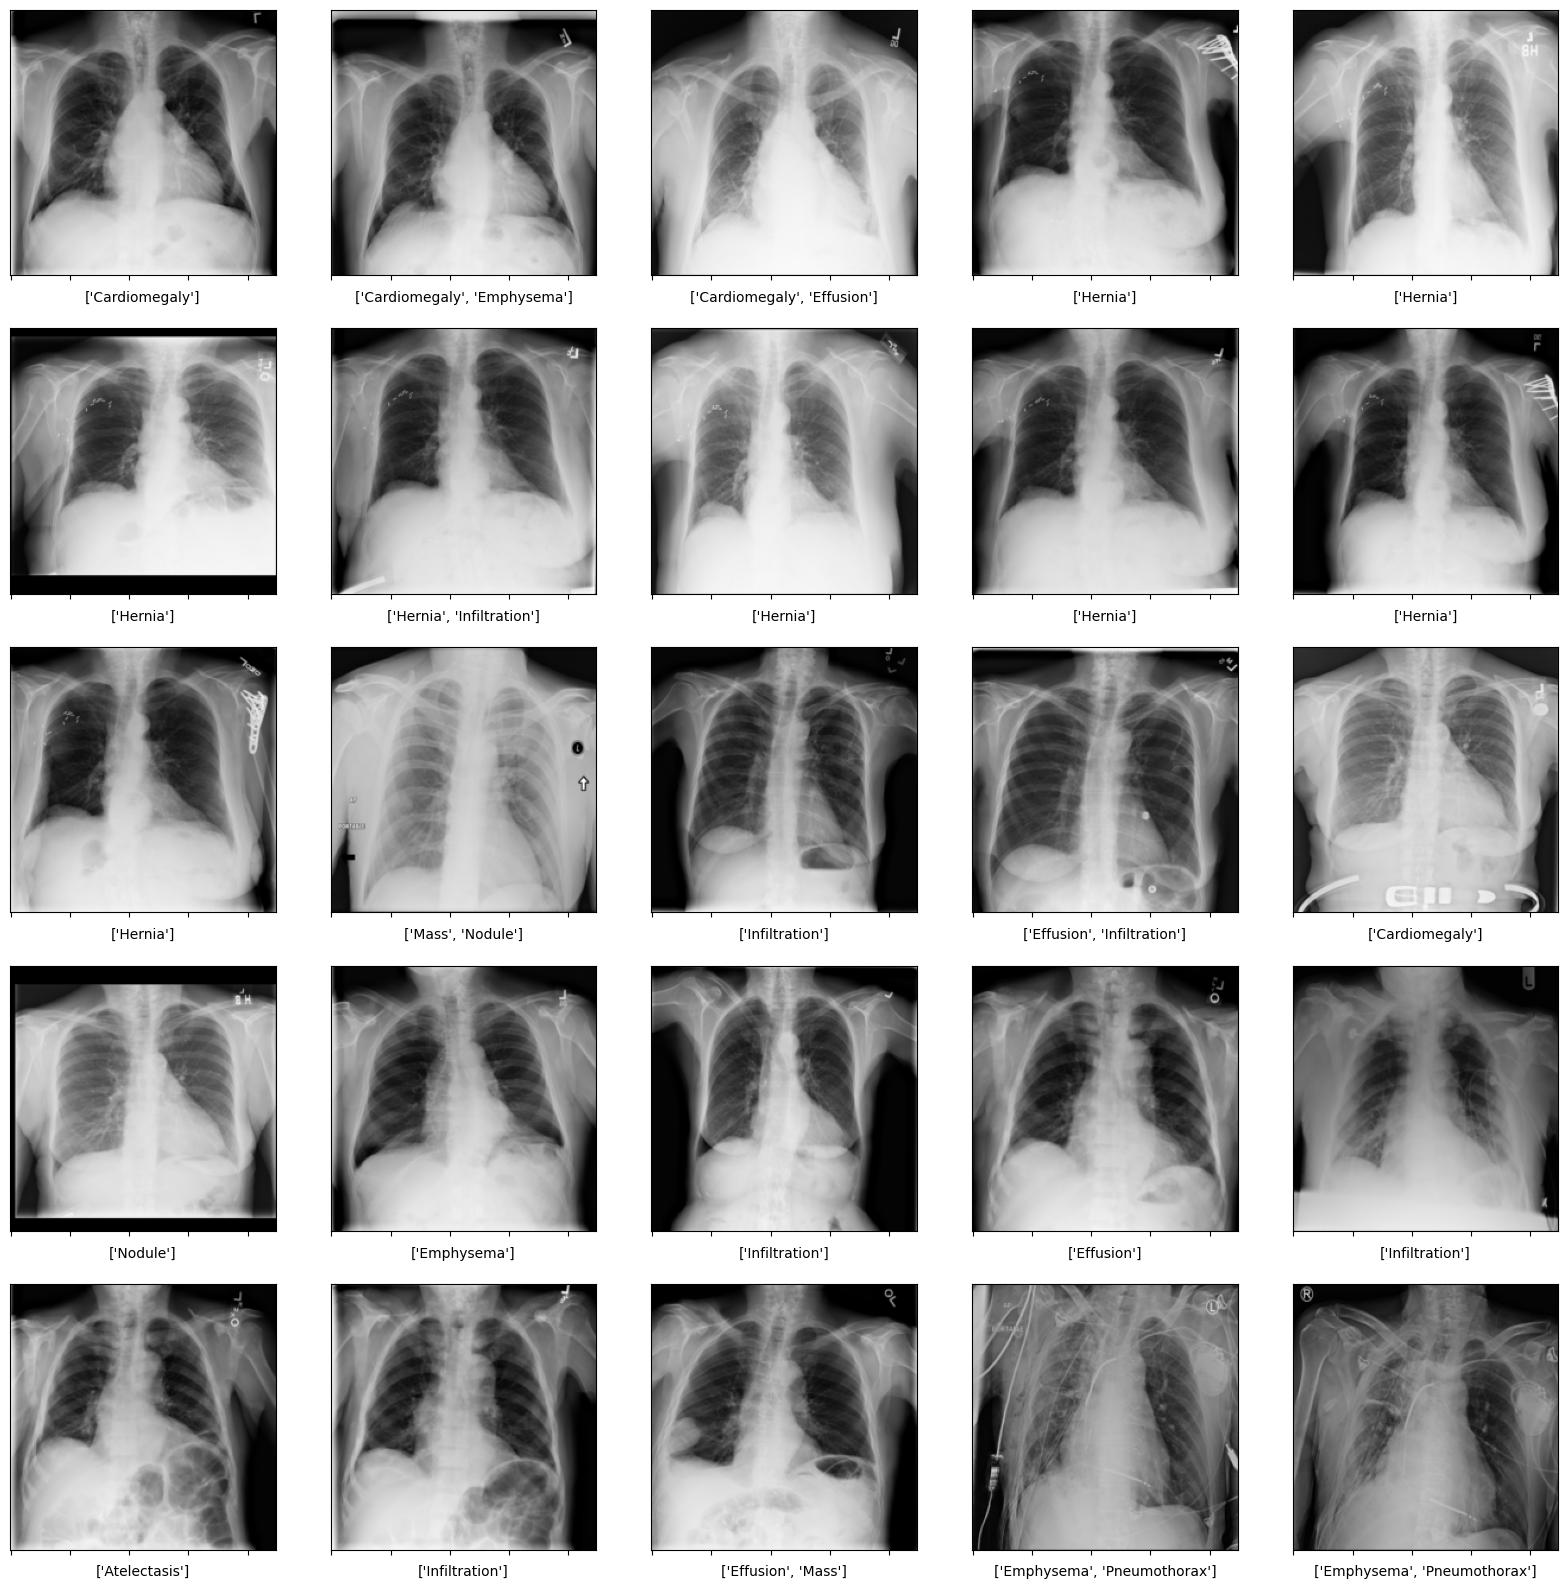

In [18]:
plot_images(df, 5, 5)

## PyTorch Dataset

In [22]:
class ChestXData(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)   # FIXED

    def __getitem__(self, idx):
        image = Image.open(self.df["Image Index"].values[idx]).convert("RGB")
        label = self.df.iloc[idx, 2:].values.astype("float32")

        if self.transform:
            image = self.transform(image=np.asarray(image))["image"]

        return image, torch.tensor(label)


In [20]:
transforms_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
])
transforms_val = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])
transforms_test = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])



### Split the dataset

#### Split into Train & Test & Validation

In [23]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_ds = ChestXData(train_df, transforms_train)
val_ds   = ChestXData(val_df, transforms_val)
test_ds  = ChestXData(test_df, transforms_test)


In [40]:
train_df.head()

,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
9172,/root/.cache/kagglehub/datasets/khanfashee/nih...,Pneumothorax,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6760,/root/.cache/kagglehub/datasets/khanfashee/nih...,Infiltration,0,0,0,1,0,0,0,0,0,0,0,0,0,0
39835,/root/.cache/kagglehub/datasets/khanfashee/nih...,Atelectasis|Effusion|Infiltration,1,0,1,1,0,0,0,0,0,0,0,0,0,0
11681,/root/.cache/kagglehub/datasets/khanfashee/nih...,Atelectasis,1,0,0,0,0,0,0,0,0,0,0,0,0,0
17847,/root/.cache/kagglehub/datasets/khanfashee/nih...,Effusion|Infiltration,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [24]:
print(f"The lengths of train, val and test dataset: {len(train_ds)} images, {len(val_ds)} images, and {len(test_ds)} images")

The lengths of train, val and test dataset: 33092 images, 8274 images, and 10342 images


In [25]:
ds_size = {
    "train": len(train_ds), "val": len(val_ds), "test": len(test_ds)
} # Size dictionary

In [26]:
ds_size

{'train': 33092, 'val': 8274, 'test': 10342}

### Create the DataLoader(s)

In [27]:
loaders = {
    "train": DataLoader(train_ds, batch_size=64, shuffle=True),
    "val": DataLoader(val_ds, batch_size=32),
    "test": DataLoader(test_ds, batch_size=32)
}

In [28]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7d245772e0c0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7d24578b0980>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7d2459aacbf0>}

## PyTorch Model

In [38]:

class ResNet50MultiLabel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        in_features = self.model.fc.in_features

        self.model.fc = nn.Linear(in_features, n_classes)  # no sigmoid!

    def forward(self, x):
        return self.model(x)


## Training

In [30]:
ds_batches = {k : len(v) for k, v in loaders.items()}
print(f" batches {ds_batches}")

 batches {'train': 518, 'val': 259, 'test': 324}


In [31]:
# check is models folder exists
Path("models").mkdir(exist_ok=True)

# Set up logger
logging.basicConfig(
    filename="train.log",
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    filemode="w",
)

In [35]:
df.head()

,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,/root/.cache/kagglehub/datasets/khanfashee/nih...,Cardiomegaly,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,/root/.cache/kagglehub/datasets/khanfashee/nih...,Cardiomegaly|Emphysema,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,/root/.cache/kagglehub/datasets/khanfashee/nih...,Cardiomegaly|Effusion,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,/root/.cache/kagglehub/datasets/khanfashee/nih...,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [39]:

n_classes=len(CFG.CLASS_NAMES)
print(f"Number of classes: {n_classes}")

model = ResNet50MultiLabel(n_classes=len(CFG.CLASS_NAMES)).to(CFG.DEVICE)

criterion = nn.BCEWithLogitsLoss()  # correct for multi-label
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Number of classes: 14
input features 2048


In [41]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images = images.to(CFG.DEVICE)
        labels = labels.to(CFG.DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def validate(model, loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

    return total_loss / len(loader)


In [42]:
epochs = 5
import os
best_val_loss = float("inf")

for epoch in range(epochs):
    train_loss = train_one_epoch(model, loaders["train"], optimizer, criterion)
    val_loss = validate(model, loaders["val"], criterion)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        path=os.path.join(CFG.BEST_MODEL_PATH, "best_resnet50.pth")
        torch.save(model.state_dict(), "best_resnet50.pth")
        print("🔥 Saved new best model!")


Epoch 1/5 | Train Loss: 0.2836 | Val Loss: 0.2677
🔥 Saved new best model!
Epoch 2/5 | Train Loss: 0.2502 | Val Loss: 0.2500
🔥 Saved new best model!
Epoch 3/5 | Train Loss: 0.2369 | Val Loss: 0.2503
Epoch 4/5 | Train Loss: 0.2236 | Val Loss: 0.2515
Epoch 5/5 | Train Loss: 0.2069 | Val Loss: 0.2589


In [43]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in loaders["test"]:
        images = images.to(CFG.DEVICE)

        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu()

        all_labels.append(labels)
        all_preds.append(probs)

all_labels = torch.cat(all_labels).numpy()
all_preds  = torch.cat(all_preds).numpy()


In [44]:
all_labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [45]:
all_preds

array([[1.25395775e-01, 2.66974717e-02, 7.12080181e-01, ...,
        1.31178871e-02, 7.54146948e-02, 8.58558982e-04],
       [1.10309526e-01, 1.58957380e-03, 9.00114700e-02, ...,
        8.86246935e-02, 4.99324463e-02, 3.17012775e-03],
       [1.59058683e-02, 2.30851304e-03, 5.38162477e-02, ...,
        6.15616627e-02, 4.09004316e-02, 3.37031699e-04],
       ...,
       [1.60651475e-01, 2.04080320e-03, 2.68610828e-02, ...,
        1.70731656e-02, 2.45234706e-02, 4.77874046e-03],
       [1.07249476e-01, 2.79638125e-03, 1.62894744e-02, ...,
        2.78829157e-01, 9.05152485e-02, 2.55813636e-02],
       [5.84119260e-01, 7.65976496e-03, 1.24757312e-01, ...,
        7.19573125e-02, 3.68640795e-02, 1.80442422e-03]], dtype=float32)

In [46]:
from sklearn.metrics import roc_auc_score

aucs = {}
for i, name in enumerate(CFG.CLASS_NAMES):
    try:
        auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
        aucs[name] = auc
    except:
        aucs[name] = None


In [47]:
valid_scores = [v for v in aucs.values() if v is not None]
mean_auc = sum(valid_scores) / len(valid_scores)
print("Mean AUROC:", mean_auc)



Mean AUROC: 0.7941896001651084


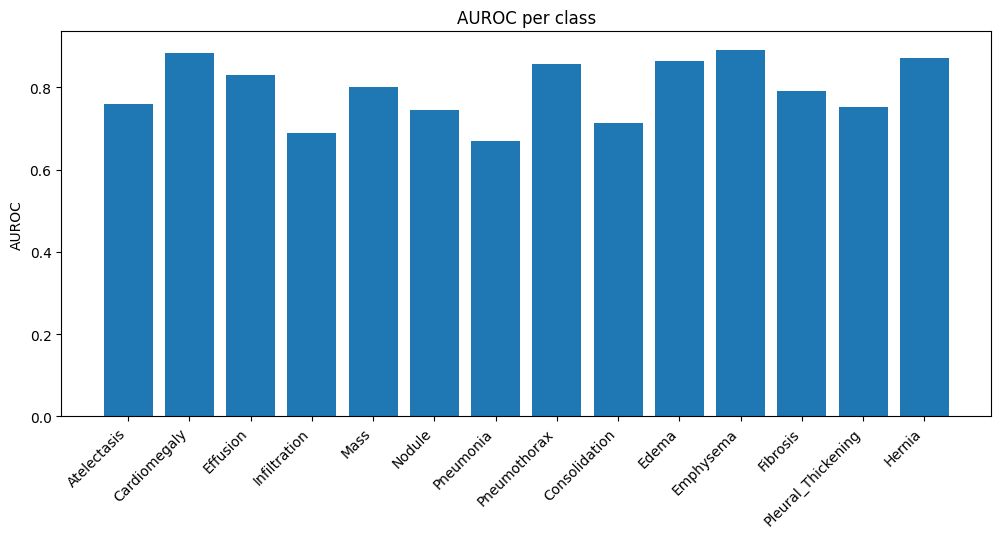

In [48]:
import matplotlib.pyplot as plt

names = list(aucs.keys())
values = [0 if v is None else v for v in aucs.values()]

plt.figure(figsize=(12,5))
plt.bar(names, values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("AUROC")
plt.title("AUROC per class")
plt.show()


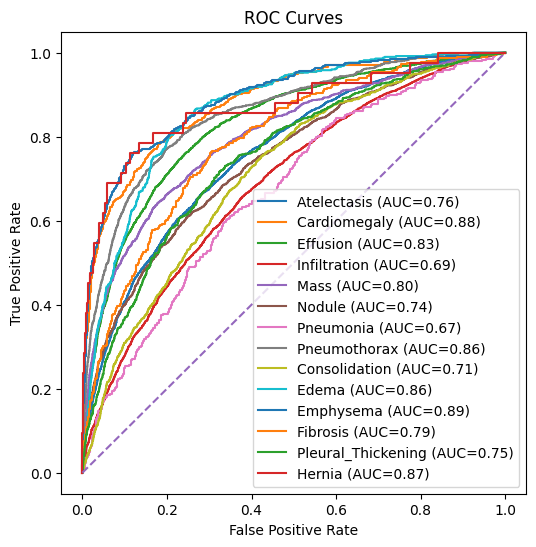

In [49]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(6,6))

for i, name in enumerate(CFG.CLASS_NAMES):
    try:
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
        plt.plot(fpr, tpr, label=f"{name} (AUC={aucs[name]:.2f})")
    except:
        pass

plt.plot([0,1],[0,1],'--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


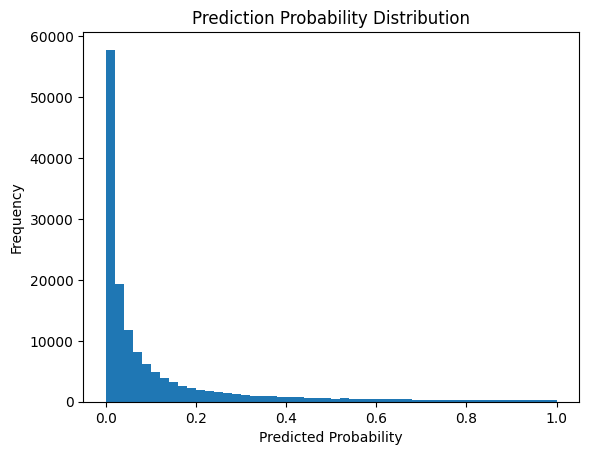

In [50]:
plt.hist(all_preds.flatten(), bins=50)
plt.title("Prediction Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()
